In [130]:
import torch
from utils import process_dataset
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import numpy as np
import random

seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [131]:
# datasets = "../datasets/pondlet_gloss_HSK3_2021-all.csv;../datasets/pondlet_STB_HSK3_2021-all.csv"
datasets = "../datasets/pondlet_STB_HSK3_20220429_new.csv"
# datasets = "../datasets/pondlet_STB_2021-all.csv"
balance_data = process_dataset(datasets)
balance_data.drop("ID", inplace=True, axis=1)
# balance_data.drop("None", inplace=True, axis=1)
# balance_data.drop("7-9", inplace=True, axis=1)

X = balance_data.iloc[:, 1:].to_numpy()

le = preprocessing.LabelEncoder()
le.fit(balance_data.Label)
balance_data['categorical_label'] = le.transform(balance_data.Label)
y = balance_data.iloc[:, -1].to_numpy()


# ['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6']
print(le.classes_)


X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.1, stratify=y_tmp, random_state=42)

datasets ../datasets/pondlet_STB_HSK3_20220429_new.csv
len-balance_data(one) 1616
['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6']


In [132]:
balance_data.Label.value_counts()

Lv.4    614
Lv.5    304
Lv.3    280
Lv.2    148
Lv.1    136
Lv.6    134
Name: Label, dtype: int64

In [133]:
import umap

In [134]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(balance_data.drop("Label", axis=1))

In [135]:
embedding.shape

(1616, 2)

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [137]:
fig_2d = px.scatter(
    embedding, x=0, y=1,
    color=balance_data.Label, labels={'color': 'Label'}
)

In [138]:
fig_2d.show()

In [139]:
X.shape

(1616, 9)

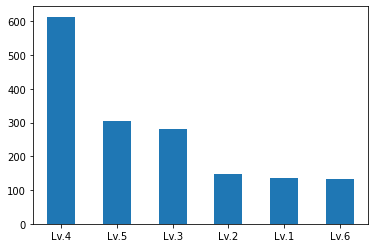

In [140]:
balance_data.Label.value_counts().plot.bar(rot=0);

In [141]:
y_train.shape, y_val.shape, y_test.shape

((1308,), (146,), (162,))

In [142]:
y_tmp.shape

(1454,)

In [143]:
le.inverse_transform([y_train[0]])

array(['Lv.3'], dtype=object)

In [144]:
le.classes_.tolist()

['Lv.1', 'Lv.2', 'Lv.3', 'Lv.4', 'Lv.5', 'Lv.6']

In [145]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [146]:
class Model(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 16)
        self.layer4 = nn.Linear(16, 16)        
        self.layer5 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)


In [147]:
model     = Model(X_train.shape[1], len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

In [148]:
model

Model(
  (layer1): Linear(in_features=9, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=16, bias=True)
  (layer5): Linear(in_features=16, out_features=6, bias=True)
)

In [149]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [150]:
y_test.shape

torch.Size([162])

In [151]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):        
        return self.x[idx], self.y[idx]

In [152]:
train = CustomDataset(X_train, y_train)
val = CustomDataset(X_val, y_val)
test = CustomDataset(X_test, y_test)

In [153]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test, batch_size=8, shuffle=True)

In [154]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(2000)):

    train_correct = 0
    train_total = 0
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        values, indices = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (indices == labels).sum().item()

    # print(f'Accuracy: {100 * train_correct // train_total} %')
    # print("train_correct", train_correct)
    # print("train_total", train_total)
    train_acc_list.append(100 * train_correct // train_total)
    train_loss_list.append(train_loss / len(train_dataloader))

    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            values, indices = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (indices == labels).sum().item()

    # print(f'Accuracy: {100 * val_correct // val_total} %')
    # print("val_correct", val_correct)
    # print("val_total", val_total)
    val_acc_list.append(100 * val_correct // val_total)
    val_loss_list.append(val_loss / len(val_dataloader))

print('Finished Training')

100%|██████████| 2000/2000 [08:16<00:00,  4.03it/s]

Finished Training


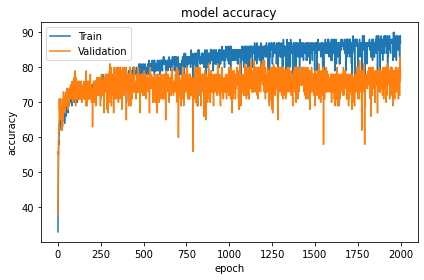

In [155]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

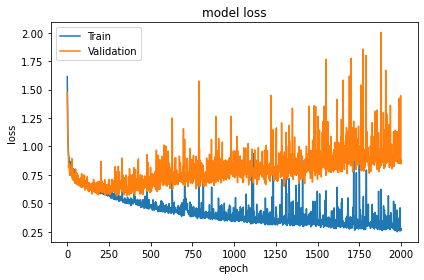

In [156]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [157]:
test_correct = 0
test_total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        values, indices = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (indices == labels).sum().item()
        
        y_true.extend(labels.tolist())
        y_pred.extend(indices.tolist())

print(f'Accuracy: {100 * test_correct / test_total} %')
print("test_correct", test_correct)
print("test_total", test_total)

Accuracy: 75.30864197530865 %
test_correct 122
test_total 162


In [158]:
from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true, y_pred)

In [159]:
array

array([[13,  0,  0,  1,  0,  0],
       [ 0,  9,  6,  0,  0,  0],
       [ 2,  1, 15, 10,  0,  0],
       [ 0,  0,  2, 51,  7,  2],
       [ 0,  0,  0,  2, 25,  3],
       [ 0,  0,  0,  1,  3,  9]])

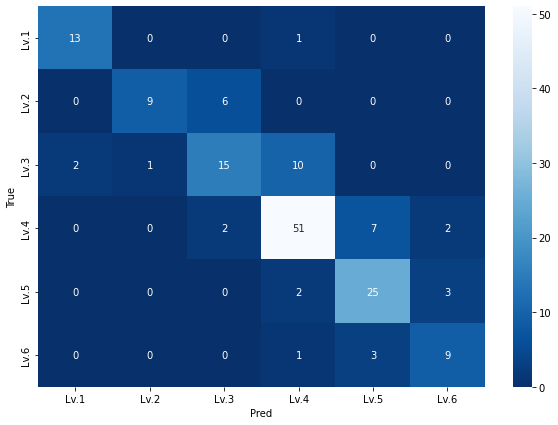

In [160]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(array, index = le.classes_.tolist(),
                  columns = le.classes_.tolist())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues_r")
plt.xlabel('Pred')
plt.ylabel('True')
plt.show();

In [161]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Lv.1       0.87      0.93      0.90        14
        Lv.2       0.90      0.60      0.72        15
        Lv.3       0.65      0.54      0.59        28
        Lv.4       0.78      0.82      0.80        62
        Lv.5       0.71      0.83      0.77        30
        Lv.6       0.64      0.69      0.67        13

    accuracy                           0.75       162
   macro avg       0.76      0.74      0.74       162
weighted avg       0.76      0.75      0.75       162



In [162]:
class BinaryModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(BinaryModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))        
        return self.layer3(x)

class CLSModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(CLSModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))        
        return self.layer3(x)

In [163]:
binary_model = BinaryModel(input_dim=9, output_dim=1)
binary_model.load_state_dict(torch.load("./binary.pt"))
binary_model.eval()

cls123_model = CLSModel(input_dim=9, output_dim=3)
cls123_model.load_state_dict(torch.load("./cls123.pt"))
cls123_model.eval()

cls456_model = CLSModel(input_dim=9, output_dim=3)
cls456_model.load_state_dict(torch.load("./cls456.pt"))
cls456_model.eval()

model.eval()

Model(
  (layer1): Linear(in_features=9, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=16, bias=True)
  (layer5): Linear(in_features=16, out_features=6, bias=True)
)

In [164]:
test_correct = 0
test_total = 0

cls456_mapping = {0:3, 1:4, 2:5}
cls123_mapping = {0:0, 1:1, 2:2}
y_true_list, y_pred_list = [], []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = binary_model(inputs)
        cls456_outputs = cls456_model(inputs)
        cls123_outputs = cls123_model(inputs)
        
        y_pred = (torch.sigmoid(outputs.data) > 0.5).float()

        for idx, b_y in enumerate(y_pred):
            # cls456
            if b_y > 0:                
                _, max_idx = torch.max(cls456_outputs[idx], dim=0)
                y_pred_list.append(cls456_mapping[max_idx.item()])
            else:
                _, max_idx = torch.max(cls123_outputs[idx], dim=0)
                y_pred_list.append(cls123_mapping[max_idx.item()])

        y_true_list.extend(labels.tolist())


In [165]:
len(y_true_list), len(y_pred_list)

(162, 162)

In [166]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_list, y_pred_list)

0.48148148148148145

In [167]:
test_correct = 0
test_total = 0

cls456_mapping = {0:3, 1:4, 2:5}
cls123_mapping = {0:0, 1:1, 2:2}

y_true_list, y_pred_list = [], []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        binary_outputs = binary_model(inputs)
        outputs = model(inputs)

        y_pred = (torch.sigmoid(binary_outputs.data) > 0.5).float()

        for idx, b_y in enumerate(y_pred):
            if b_y > 0:
                _, max_idx = torch.max(outputs[idx][3:], dim=0)
                y_pred_list.append(cls456_mapping[max_idx.item()])
            else:
                _, max_idx = torch.max(outputs[idx][:3], dim=0)
                y_pred_list.append(cls123_mapping[max_idx.item()])

        y_true_list.extend(labels.tolist())


In [168]:
print(y_true_list)

[3, 1, 5, 5, 0, 1, 5, 0, 3, 4, 2, 2, 4, 5, 2, 3, 3, 2, 0, 3, 4, 3, 4, 2, 3, 2, 3, 2, 3, 4, 4, 3, 3, 2, 4, 3, 4, 5, 5, 3, 3, 3, 3, 1, 3, 1, 3, 3, 2, 5, 4, 3, 3, 4, 4, 1, 2, 1, 2, 0, 4, 4, 1, 4, 5, 3, 2, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 4, 2, 2, 2, 3, 4, 3, 4, 0, 2, 0, 1, 1, 4, 4, 2, 3, 3, 4, 3, 3, 0, 3, 3, 0, 3, 0, 3, 2, 3, 1, 1, 3, 2, 5, 2, 0, 4, 4, 3, 2, 4, 3, 4, 3, 4, 2, 2, 3, 2, 5, 3, 3, 2, 2, 3, 3, 3, 3, 0, 3, 5, 3, 2, 4, 3, 3, 4, 1, 3, 3, 1, 4, 3, 3, 4, 2, 5, 0, 4, 0, 5]


In [169]:
print(y_pred_list)

[3, 3, 4, 5, 0, 1, 4, 0, 3, 4, 3, 3, 4, 5, 3, 3, 4, 3, 3, 3, 4, 3, 4, 2, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 5, 5, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 5, 4, 3, 3, 4, 4, 1, 3, 1, 3, 3, 4, 5, 1, 4, 5, 3, 3, 3, 4, 3, 3, 3, 3, 3, 1, 5, 2, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 0, 2, 3, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 5, 3, 0, 4, 5, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 4, 3, 3, 0, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 0, 4, 3, 5]


In [170]:
accuracy_score(y_true_list, y_pred_list)

0.6234567901234568

In [171]:
from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true_list, y_pred_list)

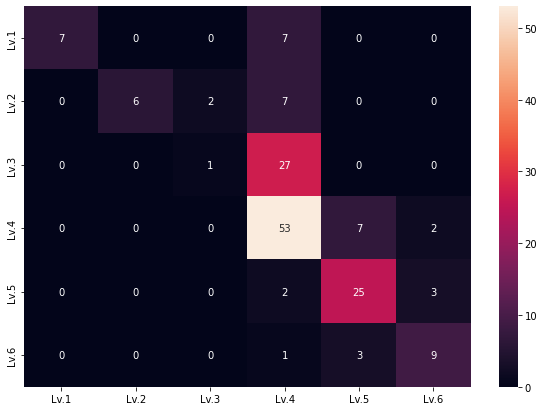

In [172]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(array, index = le.classes_.tolist(),
                  columns = le.classes_.tolist())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show();

In [173]:
from sklearn.metrics import classification_report

print(classification_report(y_true_list, y_pred_list, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Lv.1       1.00      0.50      0.67        14
        Lv.2       1.00      0.40      0.57        15
        Lv.3       0.33      0.04      0.06        28
        Lv.4       0.55      0.85      0.67        62
        Lv.5       0.71      0.83      0.77        30
        Lv.6       0.64      0.69      0.67        13

    accuracy                           0.62       162
   macro avg       0.71      0.55      0.57       162
weighted avg       0.63      0.62      0.57       162

